# <center>Домашнее задание
## Сверточные сети
Необязательное домашнее задание
1. Реализовать сверточный автокодировщик
2. Сделать оптимизацию изображения под активацию сверточных нейронов классификатора
3. Сделать оптимизацию изображения под активацию сверточных нейронов автокодировщика

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import torchvision
# from torchvision import models, transforms
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy

from utils import mnist, plot_graphs, plot_mnist, mnist_transform

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Задача

1. Обучите свою маленькую сверточную сеть с нуля на MNIST или FashionMNIST
2. Поставьте модель в eval()
3. Создайте тензор картинки, которую нужно будет оптимизировать.
4. Задайте функцию потерь.
5. Допишите функцию, которая оптимизирует картинку под вашу функцию потерь и выдаёт её.

**ПРИМЕР** ниже.

In [3]:
# Вот так можно создать обучаемый тензор со случайными числами и с размерностью картинки 1*28*28
image = torch.randn((1,28,28))*0.001
image = image.to(device)
image.requires_grad = True

На этом этапе у вас уже есть обученная модель с фиксированными параметрами (вы не хотите их больше обучать).

В данном примере в качестве "модели" я возьму пару линейных слоёв.

In [4]:
model = torch.nn.Sequential(
torch.nn.Linear(in_features=1*28*28, out_features=50),
torch.nn.Tanh(),
torch.nn.Linear(in_features=50, out_features=3),
torch.nn.Softmax(dim=1)
)

In [5]:
# так мы переводим модель в режим inference [вывод предсказаний],
# это особенно важно, если в вашей моделе есть такие слои как Dropout/Batchnorm
# потому что в процессе оптимизации картинки вы не хотите чтобы параметры сети менялись
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=3, bias=True)
  (3): Softmax(dim=1)
)

In [6]:
# быстрая проверка что сейчас выдаёт модель на картинку
model.to(device)
image.to(device)

# вам не нужно будет делать flatten в случае сверточной модели
output = model(image.flatten().unsqueeze(0))
output

tensor([[0.3677, 0.2964, 0.3358]], grad_fn=<SoftmaxBackward>)

In [7]:
torch.argmax(output)

tensor(0, grad_fn=<NotImplemented>)

Теперь необходимо дописать вот эту функцию, которая принимает на вход номер класса (**class_number**) (в моем примере классов всего 3 на выходе), и производит оптимизацию над картинкой так чтобы было верным условие:

``torch.argmax(model(image)) == class_number``

Для этого нужно задать условие на функцию потерь. Это уже часть вашего задания понять как это сделать.

В своем примере я покажу как оптимизировать картинку, чтобы генерируемая картинка классифицировалась как заданный класс

In [8]:
def optimize_image_by_class(class_number, num_steps=50000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    loss = ...
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        ...
    
    # возвращаете картинку, grads, losses

Все те же шаги было бы интересно повторить уже не со свёрточным классификатором на MNIST, а со свёрточным автоэнкодером.

### данные MNIST

In [11]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform, 
                                  path='./../MNIST_data')

## <center>Классификатор

### 1. Делаем сверточный классификатор и обучаем

In [12]:
class Net(nn.Module):
    def __init__(self, lr=1e-3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # --> 
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.loss_fn = nn.CrossEntropyLoss()
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28 24 12
        x = self.pool(F.relu(self.conv2(x)))  # 12 8 4
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.argmax(1, keepdim=True)
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [13]:
def train(epoch, models, loader, log=None, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [14]:
def test(epoch, model, loader, log=None, verbose_num=1):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.argmax(1, keepdim=True) # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    
    if epoch == 1 or epoch % verbose_num == 0:
        lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
        report = '\tTest set: ' + lines
        print(report)

In [15]:
%%time

models = {'first_model': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, test_loader, train_log)
    for model in models.values():
        model.eval()
    test(epoch, models, test_loader, test_log)

Epoch: 1 [10000]
	Train set: first_model: loss: 0.803193
	Test set: first_model: Loss: 0.5971	Accuracy: 8193.0/10000 (82%)

Epoch: 2 [10000]
	Train set: first_model: loss: 0.448648
	Test set: first_model: Loss: 0.2545	Accuracy: 9232.0/10000 (92%)

Epoch: 3 [10000]
	Train set: first_model: loss: 0.278372
	Test set: first_model: Loss: 0.1717	Accuracy: 9485.0/10000 (95%)

Epoch: 4 [10000]
	Train set: first_model: loss: 0.208636
	Test set: first_model: Loss: 0.1343	Accuracy: 9588.0/10000 (96%)

Epoch: 5 [10000]
	Train set: first_model: loss: 0.163320
	Test set: first_model: Loss: 0.1042	Accuracy: 9686.0/10000 (97%)

Epoch: 6 [10000]
	Train set: first_model: loss: 0.153722
	Test set: first_model: Loss: 0.0846	Accuracy: 9736.0/10000 (97%)

Epoch: 7 [10000]
	Train set: first_model: loss: 0.131259
	Test set: first_model: Loss: 0.0723	Accuracy: 9769.0/10000 (98%)

Epoch: 8 [10000]
	Train set: first_model: loss: 0.095738
	Test set: first_model: Loss: 0.0623	Accuracy: 9798.0/10000 (98%)

Epoch: 9

### посмотрим кривые обучения

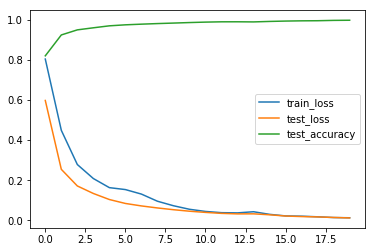

In [16]:
plt.plot(train_log["first_model"], label="train_loss")
plt.plot(list(map(lambda x: x[0], test_log["first_model"])), label="test_loss")
plt.plot(list(map(lambda x: x[1], test_log["first_model"])), label="test_accuracy")
plt.legend();

### 2. Генерируем и оптимизируем изображение под заданный класс

#### функция для оптимизации изображения под заданный класс

In [36]:
def optimize_image_by_class(class_number, model, num_steps=50000):
    model.eval()
    
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1, 28, 28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        loss = F.cross_entropy(output, torch.tensor([class_number]))
        loss.backward()
        optim.step()
        
        losses.append(loss)
        grads.append(image.grad.norm())
    
    # возвращаете картинку, grads, losses
    return image, grads, losses

In [37]:
model = models["first_model"]
class_number = 8

image, grads, losses = optimize_image_by_class(class_number, model, num_steps=5000)

100%|████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 181.39it/s]


#### проверим соответствие классу

In [38]:
(torch.argmax(model(image.unsqueeze(0))) == class_number).item()

True

#### сгенерированное и оптимизированное изображение под класс

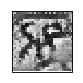

8


In [44]:
to_plot = image.unsqueeze(0).data.cpu().numpy()

plot_mnist(to_plot, (1, 1))
print(class_number)

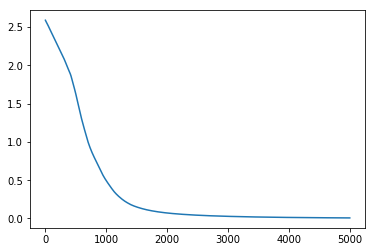

In [40]:
plt.plot(losses);

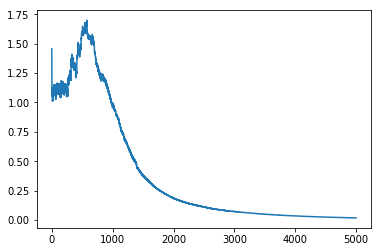

In [41]:
plt.plot(grads);

## <center>Автокодировщик

### 1. Реализуем и обучим сверточный автокодировщик

In [45]:
class Encoder(nn.Module):
    def __init__(self, channels=16, latent_size=10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(28*28*channels, latent_size)
        self.channels = channels
    
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 28*28*self.channels)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, channels=16, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28*channels)
        self.convtrans1 = nn.ConvTranspose2d(in_channels=channels, out_channels=1, kernel_size=5, stride=1, padding=2)
        self.channels = channels
    
    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, self.channels, 28, 28)
        x = self.convtrans1(x)
        x = torch.tanh(x)
        return x

In [46]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size).to(device)
        self.D = Decoder(latent_size).to(device)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        out = self.D(h)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [50]:
def train(epoch, models, loader, log=None, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        
        for model in models.values():
            model = model.to(device)
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [51]:
def test(epoch, models, loader, log=None, verbose_num=1):
    test_size = len(loader.sampler)

    test_loss = {mod_label: 0. for mod_label in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            if noise:
                noised = add_noise(data, mode, elementwise)
            else:
                noised = data
            
            output = {mod_label: model(noised) for mod_label, model in models.items()}
            for mod_label, model in models.items():
                test_loss[mod_label] += model.loss(output[mod_label], noised, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    if epoch == 1 or epoch % verbose_num == 0:
        avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
        line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
        
        losses = ' '.join([line(k, test_loss[k]) for k in models])
        report = '\t' + 'Test set: ' + losses   
        print(report)

#### Тренируем автокодировщики с 32-мерным латентным слоем

In [52]:
def train_test_models(epoch, models, train_log=None, test_log=None):
    for epoch in np.arange(epoch) + 1:
        for model in models.values():
            model.train()
        train(epoch, models, train_loader, train_log)
        for model in models.values():
            model.eval()
        test(epoch, models, test_loader, test_log)

In [69]:
%%time

ae_models = {'32': Net(32)}
train_log = {k: [] for k in ae_models}
test_log = {k: [] for k in ae_models}

train_test_models(20, ae_models)

Epoch: 1 [60000]
	Train set: 32: loss: 0.301779
	Test set: 32: loss: 0.3012
Epoch: 2 [60000]
	Train set: 32: loss: 0.249621
	Test set: 32: loss: 0.2510
Epoch: 3 [60000]
	Train set: 32: loss: 0.203139
	Test set: 32: loss: 0.2017
Epoch: 4 [60000]
	Train set: 32: loss: 0.177346
	Test set: 32: loss: 0.1732
Epoch: 5 [60000]
	Train set: 32: loss: 0.145378
	Test set: 32: loss: 0.1443
Epoch: 6 [60000]
	Train set: 32: loss: 0.141361
	Test set: 32: loss: 0.1346
Epoch: 7 [60000]
	Train set: 32: loss: 0.132482
	Test set: 32: loss: 0.1305
Epoch: 8 [60000]
	Train set: 32: loss: 0.130169
	Test set: 32: loss: 0.1277
Epoch: 9 [60000]
	Train set: 32: loss: 0.126810
	Test set: 32: loss: 0.1257
Epoch: 10 [60000]
	Train set: 32: loss: 0.122253
	Test set: 32: loss: 0.1241
Epoch: 11 [60000]
	Train set: 32: loss: 0.128327
	Test set: 32: loss: 0.1231
Epoch: 12 [60000]
	Train set: 32: loss: 0.124329
	Test set: 32: loss: 0.1221
Epoch: 13 [60000]
	Train set: 32: loss: 0.126667
	Test set: 32: loss: 0.1213
Epoch: 1

#### посмотрим на кривые обучения

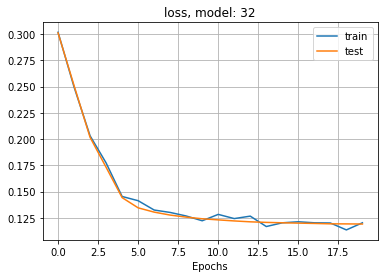

In [70]:
for model in ae_models:
    plt.plot(train_log[model], label="train")
    plt.plot(test_log[model], label="test")
    plt.title(f"loss, model: {model}")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

#### функция для оптимизации изображения под активацию сверточных нейронов автокодировщика

In [81]:
def optimize_image_by_convactivation(model, num_steps=50000):
    model.eval()
    
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1, 28, 28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model.E.conv1(image.unsqueeze(0))
#         loss = F.cross_entropy(output, torch.tensor([class_number]))
        loss = -output.abs().mean()
        loss.backward()
        optim.step()
        
        losses.append(loss)
        grads.append(image.grad.norm())
    
    # возвращаете картинку, grads, losses
    return image, grads, losses

In [82]:
image, grads, losses = optimize_image_by_convactivation(ae_models["32"], num_steps=5000)

100%|████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 220.82it/s]


#### сгенерированное и оптимизированное изображение

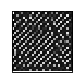

In [83]:
to_plot = image.unsqueeze(0).data.cpu().numpy()

plot_mnist(to_plot, (1, 1))

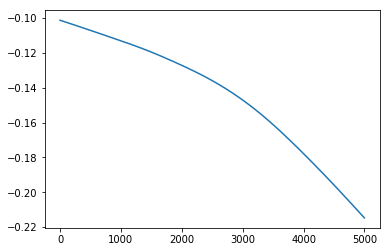

In [84]:
plt.plot(losses);

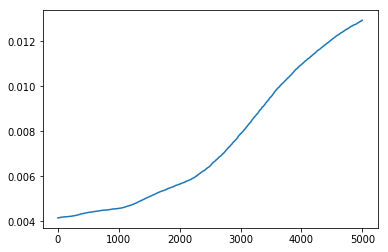

In [85]:
plt.plot(grads);